# BRIDGET: CDC DIABETES

Balanced version: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset


## Dataset Preprocessing


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
import json
import yaml
import random
import time
import functools
import pickle
import re
import orjson
import alibi
import ignite
import copy

from IPython import display
from itertools import combinations, product
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optimizer

import fatf.utils.data.datasets as fatf_datasets
import fatf.fairness.data.measures as fatf_dfm
import fatf.utils.data.tools as fatf_data_tools

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import optim
from river import metrics
from river import feature_extraction, feature_selection
from river import ensemble, linear_model, forest, compose

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

from alibi.explainers.cfproto import CounterFactualProto

from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from bridget_mod import BRIDGET, HiC, MiC


In [17]:
data= pd.read_csv(r".\datasets\diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
data.duplicated()
data.drop_duplicates()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


In [ ]:
# Qui definiamo i vari split dei flussi 

data = data.sample(frac=1, random_state=42).reset_index(drop=True)
lenght= len(data)

# split di avviamento: i primi 1k records per l'avviamento, 200 per vedere accuracy 

hic_start= 1200
hic_end= int(lenght*0.60)
calib= int(lenght*0.80)

hic_total_size = hic_end - hic_start
hic_split = hic_start + int(hic_total_size * 0.8)

avv_train = data.iloc[:1000]
avv_test= data.iloc[1000:hic_start]


hic_train = data.iloc[hic_start:hic_split]
hic_test  = data.iloc[hic_split:hic_end]

calib_end = int(lenght * 0.8)
calibration_data = data.iloc[hic_end:calib_end]
mic_data = data.iloc[calib_end:]

In [ ]:
numericals= ['BMI','MentHlth','PhysHlth']

categoricals= [c for c in data.columns if c not in numericals and c != 'Diabetes_binary']

prepr_transf = compose.Pipeline(
    ('scale', compose.TransformerUnion(
        ('numeric', compose.Select(*numericals) | preprocessing.StandardScaler()),
        ('passthrough', compose.Select(*categoricals))
    ))
)


In [ ]:
## trasformazione in df perchè servono per il logging e come lookup delle istanze (batch1 e batch3)

df_batch_1 = pd.concat([hic_train, hic_test])

df_batch_1[categoricals]=df_batch_1[categoricals].astype(int)


df_avv= pd.concat([avv_train, avv_test])
df_avv[categoricals]=df_avv[categoricals].astype(int)
df_avv.head(n=5)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,0,1,1,23.0,1,0,0,1,0,...,1,0,4,0.0,0.0,0,0,10,4,5
1,0.0,0,0,1,33.0,1,0,0,0,1,...,1,0,3,0.0,3.0,1,0,13,5,4
2,0.0,1,1,1,27.0,1,0,0,1,1,...,1,0,2,0.0,5.0,0,1,8,6,6
3,0.0,0,1,1,29.0,1,0,0,0,1,...,1,0,3,0.0,5.0,0,1,7,5,8
4,1.0,1,0,1,47.0,0,0,0,1,1,...,1,0,4,30.0,10.0,1,1,6,6,3


In [ ]:
## ora divisione in x e y

target= 'Diabetes_binary'

# avviamento 
X_avv_train = avv_train.drop(columns=[target])
y_avv_train = avv_train[target]

X_avv_test = avv_test.drop(columns=[target])
y_avv_test = avv_test[target].to_list()


# hic
X_hic_train = hic_train.drop(columns=[target])
y_hic_train = hic_train[target].to_list()

X_hic_test = hic_test.drop(columns=[target])
y_hic_test = hic_test[target].to_list()

# validation
X_val = calibration_data.drop(columns=[target])
y_val = calibration_data[target]

# mic
X_mic = mic_data.drop(columns=[target])
y_mic = mic_data[target]

## Calibration Phase: Experts and Incremental Model Selection

### Calibrating Experts

First things first, we retrieve the distribution params for the features from the experts_cdc text file

Then the users are instantied from the class BetaUser, and thus fitted to the X_hic_train data

In [22]:
with open(r".\experts_cdc_diabetes.yaml", "r") as f:
    config= yaml.safe_load(f)


params_dict= config['experts']['groups']['w_dict']
feat_order= list(config['experts']['groups']['w_dict'].keys())


In [ ]:
experts_obj= {}

expert_names = ['accurate_trusting', 'accurate_not_trusting', 
                'inaccurate_trusting', 'inaccurate_not_trusting']

X_avv_enc_df = pd.DataFrame(
    X_avv_train)

X_avv_enc_df= X_avv_enc_df[feat_order] #enforcing order just to make sure the column transformer didnt shuffle the col order


for name in expert_names:
    expert_type= config['experts']['groups'][name]

    experts_obj[name]= BetaUser(
        belief_level= expert_type['belief_value'],
        rethink_level= 0.3,
        fairness= True,
        fpr= expert_type['target_FPR'],
        fnr= expert_type['target_FNR'],
        alpha= 0.75,
        
        features_dict= params_dict,
        seed= expert_type['group_seed']
        )
    res = experts_obj[name].fit(X_avv_enc_df, y_avv_train, tol= 0.001)
    print(f"{'='*30}")
    print(f" EXPERT CALIBRATION REPORT ")
    print(f"{'='*30}")

    print(f"\n[EXPERT: {name}]")
    print(f"\n[FALSE POSITIVE RATE]")
    print(f"  - Iters:      {res['fpr iters number']}")
    print(f"  - Beta:       {res['calibrated_fpr_beta']:.4f}")
    print(f"  - Target:     {res['target_fpr']}")
    print(f"  - Achieved:   {res['achieved_fpr']:.4f}")

    print(f"\n[FALSE NEGATIVE RATE]")
    print(f"  - Iters:      {res['fnr iters number']}")
    print(f"  - Beta:       {res['calibrated_fnr_beta']:.4f}")
    print(f"  - Target:     {res['target_fnr']}")
    print(f"  - Achieved:   {res['achieved_fnr']:.4f}")
    


 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      13
  - Beta:       -13.1592
  - Target:     0.15
  - Achieved:   0.1499

[FALSE NEGATIVE RATE]
  - Iters:      9
  - Beta:       -16.0156
  - Target:     0.15
  - Achieved:   0.1499
 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      10
  - Beta:       -16.9922
  - Target:     0.15
  - Achieved:   0.1492

[FALSE NEGATIVE RATE]
  - Iters:      13
  - Beta:       -20.4346
  - Target:     0.15
  - Achieved:   0.1501
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      14
  - Beta:       -9.6069
  - Target:     0.4
  - Achieved:   0.4007

[FALSE NEGATIVE RATE]
  - Iters:      14
  - Beta:       -11.9995
  - Target:     0.4
  - Achieved:   0.3998
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      9
  - Beta:       -12.8906
  - Target:     0.4
  - Achieved

### Calibrating Incremental Model

The incremental model to be chosen for Bridget is trained on the X_avv, y_avv portion of the dataset,then evaluated on the X_avv_test and y_avv_test

The calibration phase starts by assessing the results of the learning for several configurations:

    - HoeffdingTreeClassifier

    - ExtremelyFastDecisionTreeClassifier

    - AdaBoostClassifier            (base= SGTClassifier)

    - AdwinBaggingClassifier        (base= SGTClassifier)

    - SRPClassifier                 (base= SGTClassifier)

    - AdaptiveRandomForestClassifier


The metrics observed are the Accuracy, the F1Score and the Counters for the classes

In [ ]:
# since all River models work with dicts, lets first transform the dfs to dict
X_avv_df = pd.DataFrame(X_avv_train)
X_avv_test= pd.DataFrame(X_avv_test)

X_avv_dict= X_avv_df[feat_order].to_dict(orient='records')
X_avv_dict_test= X_avv_test[feat_order].to_dict(orient='records')


# setting the init params required by HIC class
RULE = True
PAST = True
SKEPT = True
GROUP = True
EVA=    True
N_BINS = 10
N_VAR = 3
MAX = 5

test_batch_1= pd.DataFrame(X_hic_test)

test_batch_1['Diabetes_binary']= y_hic_test


target= 'Diabetes_binary'

rule_att = 'BMI' # a random rule
rule_value = 50

protected= ['Sex', 'Age']


In [ ]:
# then the models are instantiated and trained by the HiC.train function
# the HiC object is initialized by passing a random user model, its not relevant since it won't interact with the IL anyways

acc_trusting= experts_obj['accurate_trusting']

sgt_base = tree.SGTClassifier(
    grace_period=100,  # Leggermente più basso per imparare prima
    feature_quantizer=tree.splitter.DynamicQuantizer()
)


htree= tree.HoeffdingAdaptiveTreeClassifier(grace_period= 100)
efdt= tree.ExtremelyFastDecisionTreeClassifier(grace_period=100)
ada= ensemble.AdaBoostClassifier(model= sgt_base, n_models= 8, seed= 42)  
adwin= ensemble.ADWINBaggingClassifier(model= sgt_base, n_models= 8, seed= 42)
srp= ensemble.SRPClassifier(model= sgt_base, n_models=8, seed= 42)
arf= forest.ARFClassifier(n_models= 8, grace_period= 50, max_features='sqrt', seed=42)

models= [htree, efdt, ada, adwin, srp, arf]


for model in models:
    bridget_inst= HiC(acc_trusting,df_batch_1, mic_data, test_batch_1, target, prepr_transf,
                0.6, acc_trusting,
                protected, categoricals, numericals,  0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, model)

    
    bridget_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

trained_arf= arf

Accuracy: 72.50%
F1: 72.91%
Distribution of predictions: Counter({0: 103, 1: 97})
HoeffdingAdaptiveTreeClassifier trained
Accuracy: 71.00%
F1: 71.29%
Distribution of predictions: Counter({0: 104, 1: 96})
ExtremelyFastDecisionTreeClassifier trained
Accuracy: 61.50%
F1: 50.32%
Distribution of predictions: Counter({False: 151, True: 49})
AdaBoostClassifier(SGTClassifier) trained
Accuracy: 60.50%
F1: 51.53%
Distribution of predictions: Counter({False: 143, True: 57})
ADWINBaggingClassifier(SGTClassifier) trained
Accuracy: 64.00%
F1: 60.87%
Distribution of predictions: Counter({False: 122, True: 78})
SRPClassifier(SGTClassifier) trained
Accuracy: 64.00%
F1: 64.00%
Distribution of predictions: Counter({0: 106, 1: 94})
ARFClassifier trained


## BRIDGET decision making

Dopo una prima run di train HIC e testing usando HoeffdingTree e una con EFDT ho deciso di provare la run con ARF, per capire se l'accuracy e F1 iniziali riuscissero a migliorarsi sostanzialmente dopo HiC

### Expert: Accurate, Trusting (DA RIFARE PER LA NUOVA DIRECTORY)

#### HiC

In [ ]:
clean_prepr = copy.deepcopy(prepr_transf)

arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_trusting']
name= f"{'accurate_trusting'}"

    
hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, clean_prepr,
                0.80, current_expert,
                protected, categoricals, numericals, 0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, arf_mod
)

In [ ]:
hic_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

acc_t= pd.DataFrame(hic_df)

acc_t.to_csv(f".\processed_data\CDC_data\hic_results_ds\hic_{name}", index=False)  # 144 minuti

Accuracy: 70.50%
F1: 71.50%
Distribution of predictions: Counter({1: 101, 0: 99})
ARFClassifier trained


  2%|▏         | 659/41215 [00:03<03:24, 198.00it/s]

  2%|▏         | 836/41215 [00:08<07:40, 87.67it/s] 

  7%|▋         | 2727/41215 [00:39<12:21, 51.90it/s] 

  7%|▋         | 2785/41215 [00:43<16:02, 39.94it/s]  

  8%|▊         | 3222/41215 [01:02<14:43, 43.02it/s]  

  8%|▊         | 3499/41215 [01:11<16:01, 39.24it/s]  

 12%|█▏        | 4808/41215 [02:06<21:19, 28.45it/s]  

 13%|█▎        | 5163/41215 [02:24<22:47, 26.37it/s]  

 13%|█▎        | 5181/41215 [02:28<54:36, 11.00it/s]  

 13%|█▎        | 5535/41215 [02:52<27:04, 21.96it/s]  

 16%|█▌        | 6638/41215 [04:05<27:21, 21.06it/s]  

 16%|█▌        | 6671/41215 [04:10<32:46, 17.56it/s]  

 17%|█▋        | 6871/41215 [04:23<27:44, 20.63it/s]  

 17%|█▋        | 7051/41215 [04:40<29:03, 19.60it/s]  

 17%|█▋        | 7080/41215 [04:45<34:26, 16.52it/s]  

 18%|█▊        | 7571/41215 [05:22<30:51, 18.17it/s]  

 20%|█▉        | 8111/41215 [06:05<45:01, 12.25it/s]  

 20%|██        | 8437/41215 [06:46<36:59, 14.77it/s]   

 21%|██▏       | 8775/41215 [07:18<47:15, 11.44it/s]  

 21%|██▏       | 8844/41215 [07:34<47:50, 11.28it/s]  

 22%|██▏       | 9051/41215 [08:00<35:23, 15.15it/s]  

 26%|██▋       | 10921/41215 [10:35<38:48, 13.01it/s]   

 31%|███       | 12747/41215 [13:59<42:36, 11.14it/s]   

 34%|███▎      | 13871/41215 [16:02<45:20, 10.05it/s]   

 35%|███▍      | 14316/41215 [17:00<44:16, 10.13it/s]   

 35%|███▍      | 14361/41215 [17:09<43:38, 10.25it/s]  

 35%|███▌      | 14442/41215 [17:36<55:20,  8.06it/s]   

 36%|███▌      | 14730/41215 [18:11<45:02,  9.80it/s]   

 37%|███▋      | 15252/41215 [19:27<56:27,  7.67it/s]   

 41%|████      | 16932/41215 [23:21<50:35,  8.00it/s]   

 43%|████▎     | 17728/41215 [25:23<51:12,  7.64it/s]   

 45%|████▌     | 18601/41215 [28:20<51:07,  7.37it/s]   

 48%|████▊     | 19664/41215 [31:26<50:37,  7.10it/s]   

 49%|████▊     | 20002/41215 [32:39<23:25:47,  3.98s/it]

 51%|█████     | 21028/41215 [36:06<51:28,  6.54it/s]   

 54%|█████▍    | 22371/41215 [40:16<50:56,  6.17it/s]   

 55%|█████▌    | 22724/41215 [41:43<49:15,  6.26it/s]   

 56%|█████▌    | 22999/41215 [42:42<49:18,  6.16it/s]   

 57%|█████▋    | 23300/41215 [44:21<49:53,  5.98it/s]   

 57%|█████▋    | 23441/41215 [44:52<49:39,  5.97it/s]   

 58%|█████▊    | 23938/41215 [46:24<49:24,  5.83it/s]   

 60%|██████    | 24933/41215 [50:14<48:31,  5.59it/s]   

 61%|██████▏   | 25300/41215 [51:58<48:36,  5.46it/s]   

 66%|██████▌   | 27235/41215 [1:00:01<47:44,  4.88it/s] 

 67%|██████▋   | 27734/41215 [1:01:47<46:35,  4.82it/s]   

 68%|██████▊   | 27878/41215 [1:02:27<48:47,  4.56it/s]   

 69%|██████▉   | 28345/41215 [1:04:56<45:25,  4.72it/s]   

 70%|███████   | 28935/41215 [1:07:52<41:22,  4.95it/s]   

 71%|███████   | 29109/41215 [1:09:25<39:57,  5.05it/s]   

 71%|███████   | 29154/41215 [1:09:44<40:11,  5.00it/s]  

 72%|███████▏  | 29607/41215 [1:11:24<39:12,  4.94it/s]  

 73%|███████▎  | 29910/41215 [1:12:36<38:25,  4.90it/s]  

 74%|███████▍  | 30551/41215 [1:15:40<37:30,  4.74it/s]   

 75%|███████▍  | 30770/41215 [1:16:35<37:12,  4.68it/s]  

 75%|███████▍  | 30895/41215 [1:17:11<36:12,  4.75it/s]  

 76%|███████▌  | 31128/41215 [1:19:24<35:45,  4.70it/s]   

 76%|███████▋  | 31492/41215 [1:20:51<35:26,  4.57it/s]  

 77%|███████▋  | 31687/41215 [1:21:43<34:03,  4.66it/s]  

 77%|███████▋  | 31906/41215 [1:22:39<33:37,  4.61it/s]  

 78%|███████▊  | 31945/41215 [1:22:57<33:22,  4.63it/s]  

 78%|███████▊  | 31956/41215 [1:23:09<45:33,  3.39it/s]  

 80%|████████  | 33175/41215 [1:29:57<32:09,  4.17it/s]   

 81%|████████  | 33280/41215 [1:30:32<30:11,  4.38it/s]  

 81%|████████  | 33284/41215 [1:30:42<2:39:53,  1.21s/it]

 81%|████████  | 33315/41215 [1:30:59<29:56,  4.40it/s]  

 83%|████████▎ | 34072/41215 [1:35:10<28:00,  4.25it/s]   

 84%|████████▎ | 34466/41215 [1:36:55<27:04,  4.15it/s]  

 84%|████████▎ | 34489/41215 [1:37:10<26:28,  4.23it/s]  

 84%|████████▍ | 34799/41215 [1:38:35<26:05,  4.10it/s]  

 85%|████████▍ | 34831/41215 [1:38:52<25:25,  4.18it/s]  

 86%|████████▋ | 35574/41215 [1:43:55<22:49,  4.12it/s]   

 89%|████████▉ | 36850/41215 [1:50:51<18:29,  3.93it/s]   

 93%|█████████▎| 38313/41215 [2:01:14<12:27,  3.88it/s]   

 93%|█████████▎| 38395/41215 [2:01:46<12:14,  3.84it/s]  

 93%|█████████▎| 38401/41215 [2:01:58<36:59,  1.27it/s]  

 94%|█████████▍| 38787/41215 [2:03:49<10:26,  3.88it/s]  

 94%|█████████▍| 38851/41215 [2:04:17<10:14,  3.85it/s]  

 96%|█████████▋| 39716/41215 [2:10:52<06:47,  3.68it/s]   

 96%|█████████▋| 39738/41215 [2:11:08<06:42,  3.67it/s]  

100%|█████████▉| 41084/41215 [2:22:26<00:38,  3.41it/s]   

100%|█████████▉| 41133/41215 [2:22:53<00:29,  2.74it/s]

100%|██████████| 41215/41215 [2:24:08<00:00,  4.77it/s]


In [ ]:
# before saving the calibration and batch 3 sets, i use the same river scaler to ensure the exact scale is applied

def scale_df(data, pipe, target_c):  # a quanto pare usando questa pipeline di River la label viene persa per strada quindi la devo riattaccarre
    processed_r= []
    labels= data[target_c].values
    X = data.drop(columns=[target_c])

    for i,r in enumerate(X.to_dict(orient='records')):
        scaled_r = pipe.transform_one(r)
        scaled_r[target_c] = labels[i]
        processed_r.append(scaled_r)
    return pd.DataFrame(processed_r)

blueprint= pd.read_csv(r".\processed_data\CDC_data\hic_results_ds\hic_accurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]] # ridefinisco l'ordering delle feats prima delle colonne informative 

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\CDC_data\calibration_datasets\acc_t_calibration", index= False)


In [ ]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

NameError: name 'hic_feas' is not defined

#### MiC

In [92]:
acc_t_switch= pd.read_csv(r".\processed_data\CDC_data\switch_ds\acc_t_switch")
acc_t_switch = acc_t_switch.rename(columns={'g_truth':'Diabetes_binary'})

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=21, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.4) # tanto c'è self.eval quindi il dropout non viene avviato
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [93]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['Diabetes_binary']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['Diabetes_binary'].values, dtype= torch.long).to(device)


net_path= r".\nets\CDC_diabetes\acc_t_models\16_8_acc_t_model_10.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.81

In [94]:
acc_t_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.81, None)


acc_t_mic_df, processed,  mic_acc, model_acc, fea_mic, mach_confidence=acc_t_mic.start_MiC(X_stream, y_stream, acc_t_switch)   #3 minutes

  4%|▍         | 547/14139 [00:01<00:29, 467.62it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.7571295708368676), np.float64(0.7899228850640204), np.float64(0.7983245762373025), np.float64(0.8199384567443067), np.float64(0.5826169177751274)]


  4%|▍         | 561/14139 [00:01<00:34, 390.52it/s]


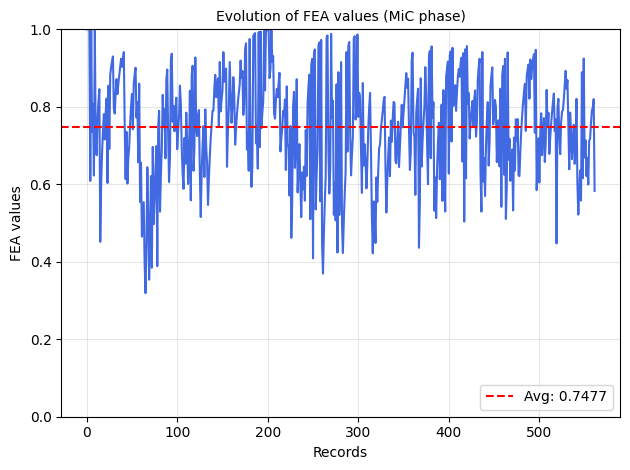

In [95]:
plt.plot(fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [96]:
print(mic_acc)
print(model_acc)
print(np.average(fea_mic))
acc_t_mic.deferred_decisions


0.9128113879003559
0.7473309608540926
0.7477425872467716


238

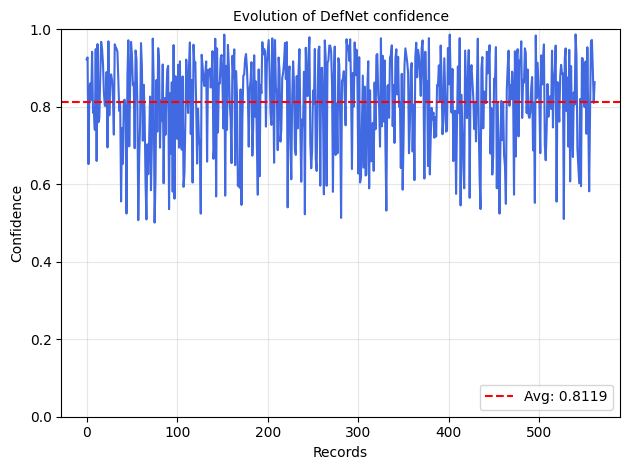

In [97]:
plt.plot(mach_confidence, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

Optimal tau= 0.132

In [ ]:
r_net_acc_t = DeferralNet(input_size=21, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.3)


r_net_acc_t.load_state_dict(torch.load('r_net_trained.pth'))
r_net_acc_t.to(device)
r_net_acc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [99]:
acc_t_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.81, anqi_mao_thresh=0.132)


acc_t_str_2, _,  mic_acc_2, model_acc_2, fea_mic_2, mach_confidence_2=acc_t_strat_2.start_MiC(X_stream, y_stream, acc_t_switch, r_net= r_net_acc_t, two_step_deferral=True)   #3 minutes

  4%|▍         | 557/14139 [00:01<00:31, 425.29it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.7571295708368676), np.float64(0.7899228850640204), np.float64(0.7983245762373025), np.float64(0.8199384567443067), np.float64(0.5826169177751274)]


  4%|▍         | 561/14139 [00:01<00:36, 372.19it/s]


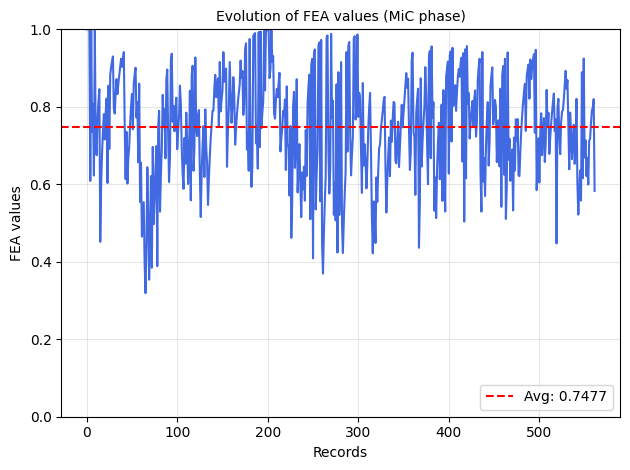

In [100]:
plt.plot(fea_mic_2, linestyle='-', color='royalblue')
avg_fea_2= np.mean(fea_mic_2)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [101]:
print(mic_acc_2)
print(model_acc_2)
print(np.average(fea_mic_2))
acc_t_strat_2.deferred_decisions



0.9181494661921709
0.7473309608540926
0.7477425872467716


242

### Expert: Inaccurate, Trusting (DA RIFARE PER LA DIRECTORY NUOVA)

#### HiC

In [ ]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_trusting']
name= f"{'inaccurate_trusting'}"
   

hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, clean_prepr,
                0.80, current_expert,
                protected, categoricals, numericals, 0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, arf_mod
)
    


In [104]:
hic_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

inacc_t_hic= pd.DataFrame(hic_df)

inacc_t_hic.to_csv(f".\processed_data\CDC_data\hic_results_ds\hic_{name}", index=False)  # 146 minuti

Accuracy: 71.00%
F1: 72.38%
Distribution of predictions: Counter({1: 104, 0: 96})
ARFClassifier trained


  1%|▏         | 576/41215 [00:05<06:45, 100.19it/s]


KeyboardInterrupt: 

In [ ]:
blueprint= pd.read_csv(r".\processed_data\CDC_data\hic_results_ds\hic_inaccurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\CDC_data\calibration_datasets\inacc_t_calibration", index= False)

In [106]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'hic_feas' is not defined

#### MiC


In [107]:
inacc_t_switch= pd.read_csv(r".\processed_data\CDC_data\switch_ds\inacc_t_switch")
inacc_t_switch = inacc_t_switch.rename(columns={'g_truth':'Diabetes_binary'})

device = torch.device("cpu")

In [ ]:
mic_net = DeferralNet(input_size=21, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.4) 
mic_net.to(device)

X_stream= torch.tensor(data= df_batch_3.drop(columns=['Diabetes_binary']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['Diabetes_binary'].values, dtype= torch.long).to(device)


net_path= r".\nets\CDC_diabetes\inacc_t_models\16_8_model_10.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence-based Deferral
Tau = 0.78 

In [109]:
inacc_t_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.78, anqi_mao_thresh= 0.2)


inacc_t_mic_df, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=inacc_t_mic.start_MiC(X_stream, y_stream, inacc_t_switch)   #3 minutes


  4%|▍         | 553/14139 [00:01<00:31, 425.02it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.80312679030017), np.float64(0.828205604344084), np.float64(0.970593706175919), np.float64(0.8515515291721615), np.float64(0.6831993105454272)]


  4%|▍         | 561/14139 [00:01<00:36, 367.05it/s]


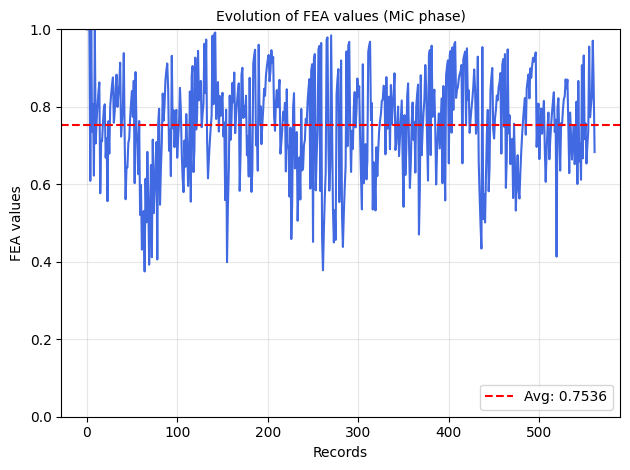

In [113]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [114]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
inacc_t_mic.deferred_decisions

0.896797153024911
0.7544483985765125


191

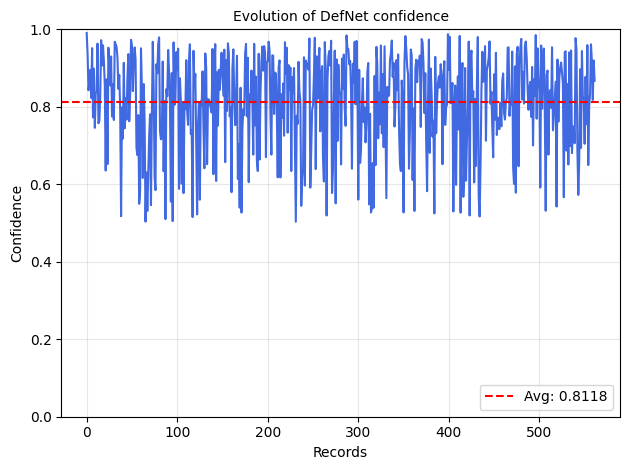

In [115]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

thresh= 0.143

In [ ]:
r_net_inacc_t = DeferralNet(input_size=21, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.3)

r_net_inacc_t.load_state_dict(torch.load('r_net_inacc_t.pth'))
r_net_inacc_t.to(device)
r_net_inacc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [117]:
inacc_t_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.78, anqi_mao_thresh= 0.143)


inacc_t_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=inacc_t_strat_2.start_MiC(X_stream, y_stream, inacc_t_switch, r_net_inacc_t, two_step_deferral=True)   #3 minutes


  4%|▍         | 546/14139 [00:01<00:34, 397.11it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.80312679030017), np.float64(0.828205604344084), np.float64(0.970593706175919), np.float64(0.8515515291721615), np.float64(0.6831993105454272)]


  4%|▍         | 561/14139 [00:01<00:40, 332.35it/s]


In [ ]:
print(mic_acc_3)
print(model_acc_3)
inacc_t_strat_2.deferred_decisions


0.8185053380782918
0.7544483985765125


83

### Expert: Accurate, Not Trusting (ok)

#### HIC

In [ ]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_not_trusting']
name= f"{'accurate_not_trusting'}"

hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, clean_prepr,
                0.80, current_expert,
                protected, categoricals, numericals, 0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, arf_mod
)
    


In [ ]:
hic_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

hic_df= pd.DataFrame(hic_df)

hic_df.to_csv(f".\processed_data\CDC_data\hic_results_ds\hic_{name}", index=False)  # 139 minuti

Accuracy: 71.00%
F1: 72.38%
Distribution of predictions: Counter({1: 104, 0: 96})
ARFClassifier trained


  1%|          | 291/41215 [00:01<02:19, 292.78it/s]

  6%|▋         | 2634/41215 [00:41<14:06, 45.59it/s]  

  7%|▋         | 2727/41215 [00:46<14:04, 45.56it/s]  

  7%|▋         | 2787/41215 [00:51<17:11, 37.27it/s]  

  8%|▊         | 3185/41215 [01:05<16:23, 38.68it/s]  

  9%|▊         | 3524/41215 [01:19<16:33, 37.93it/s]  

  9%|▉         | 3825/41215 [01:31<19:46, 31.51it/s]  

 10%|▉         | 4113/41215 [01:49<23:10, 26.69it/s]  

 12%|█▏        | 5044/41215 [02:26<21:38, 27.85it/s]  

 12%|█▏        | 5109/41215 [02:31<20:49, 28.89it/s]  

 13%|█▎        | 5163/41215 [02:36<21:24, 28.06it/s]  

 13%|█▎        | 5181/41215 [02:40<51:41, 11.62it/s]  

 14%|█▍        | 5825/41215 [03:10<22:51, 25.80it/s]  

 14%|█▍        | 5927/41215 [03:17<22:52, 25.72it/s]  

 14%|█▍        | 5972/41215 [03:22<24:27, 24.01it/s]  

 17%|█▋        | 7080/41215 [04:40<32:19, 17.60it/s]  

 18%|█▊        | 7546/41215 [05:07<28:15, 19.86it/s]  

 20%|█▉        | 8073/41215 [05:45<29:54, 18.47it/s]  

 21%|██▏       | 8775/41215 [06:39<31:30, 17.16it/s]  

 21%|██▏       | 8795/41215 [06:44<43:49, 12.33it/s]  

 22%|██▏       | 8891/41215 [06:53<32:01, 16.82it/s]  

 22%|██▏       | 8999/41215 [07:04<32:44, 16.40it/s]  

 25%|██▍       | 10277/41215 [08:45<35:25, 14.55it/s]  

 25%|██▌       | 10331/41215 [09:03<43:28, 11.84it/s]   

 27%|██▋       | 10987/41215 [09:54<37:34, 13.41it/s]  

 27%|██▋       | 10997/41215 [09:59<1:58:19,  4.26it/s]

 31%|███       | 12587/41215 [12:37<39:52, 11.97it/s]   

 35%|███▍      | 14360/41215 [15:48<42:23, 10.56it/s]   

 35%|███▍      | 14411/41215 [15:57<42:37, 10.48it/s]  

 35%|███▌      | 14559/41215 [16:27<42:44, 10.39it/s]   

 37%|███▋      | 15046/41215 [17:35<43:59,  9.91it/s]   

 40%|████      | 16689/41215 [21:02<47:20,  8.63it/s]   

 46%|████▌     | 19011/41215 [27:10<1:37:41,  3.79it/s] 

 47%|████▋     | 19242/41215 [27:45<48:05,  7.61it/s]   

 48%|████▊     | 19711/41215 [28:52<47:09,  7.60it/s]   

 49%|████▉     | 20246/41215 [30:33<46:30,  7.51it/s]   

 49%|████▉     | 20328/41215 [30:50<47:36,  7.31it/s]   

 55%|█████▌    | 22835/41215 [38:45<46:42,  6.56it/s]   

 56%|█████▌    | 22999/41215 [39:16<46:21,  6.55it/s]   

 56%|█████▌    | 23052/41215 [39:56<46:44,  6.48it/s]   

 56%|█████▌    | 23164/41215 [40:20<45:22,  6.63it/s]   

 58%|█████▊    | 23829/41215 [42:16<46:23,  6.25it/s]   

 64%|██████▍   | 26319/41215 [51:36<43:12,  5.74it/s]   

 65%|██████▌   | 26895/41215 [53:49<43:04,  5.54it/s]   

 68%|██████▊   | 27932/41215 [58:10<41:27,  5.34it/s]   

 70%|███████   | 28935/41215 [1:02:32<38:36,  5.30it/s]   

 70%|███████   | 29033/41215 [1:03:39<38:58,  5.21it/s]   

 71%|███████   | 29226/41215 [1:04:32<41:07,  4.86it/s]  

 71%|███████▏  | 29468/41215 [1:05:28<38:32,  5.08it/s]  

 72%|███████▏  | 29501/41215 [1:05:42<37:52,  5.15it/s]  

 73%|███████▎  | 29981/41215 [1:07:25<37:02,  5.05it/s]  

 75%|███████▍  | 30770/41215 [1:11:08<35:18,  4.93it/s]   

 75%|███████▍  | 30895/41215 [1:11:42<34:57,  4.92it/s]  

 75%|███████▌  | 31012/41215 [1:13:30<1:25:27,  1.99it/s] 

 76%|███████▌  | 31349/41215 [1:14:47<34:01,  4.83it/s]  

 76%|███████▌  | 31362/41215 [1:14:59<39:52,  4.12it/s]  

 76%|███████▋  | 31469/41215 [1:15:29<33:49,  4.80it/s]  

 76%|███████▋  | 31492/41215 [1:15:43<33:53,  4.78it/s]  

 76%|███████▋  | 31519/41215 [1:15:57<34:18,  4.71it/s]  

 77%|███████▋  | 31680/41215 [1:16:47<33:29,  4.75it/s]  

 77%|███████▋  | 31695/41215 [1:17:00<36:20,  4.37it/s]  

 77%|███████▋  | 31779/41215 [1:17:35<44:56,  3.50it/s]  

 77%|███████▋  | 31906/41215 [1:18:10<32:48,  4.73it/s]  

 78%|███████▊  | 32052/41215 [1:19:42<34:44,  4.40it/s]   

 78%|███████▊  | 32062/41215 [1:19:53<48:56,  3.12it/s]  

 79%|███████▊  | 32354/41215 [1:21:04<32:25,  4.55it/s]  

 79%|███████▉  | 32596/41215 [1:22:06<31:00,  4.63it/s]  

 80%|███████▉  | 32885/41215 [1:23:17<30:21,  4.57it/s]  

 81%|████████  | 33284/41215 [1:26:32<28:43,  4.60it/s]   

 82%|████████▏ | 33613/41215 [1:28:02<28:23,  4.46it/s]  

 84%|████████▎ | 34489/41215 [1:32:43<25:26,  4.41it/s]   

 85%|████████▍ | 34831/41215 [1:34:09<24:21,  4.37it/s]  

 85%|████████▍ | 34864/41215 [1:34:26<24:33,  4.31it/s]  

 85%|████████▌ | 35192/41215 [1:37:33<23:29,  4.27it/s]   

 86%|████████▌ | 35359/41215 [1:38:31<22:48,  4.28it/s]  

 87%|████████▋ | 35701/41215 [1:40:10<21:20,  4.30it/s]  

 87%|████████▋ | 35761/41215 [1:40:34<21:11,  4.29it/s]  

 87%|████████▋ | 35901/41215 [1:41:16<20:48,  4.26it/s]  

 88%|████████▊ | 36100/41215 [1:43:20<20:26,  4.17it/s]   

 90%|████████▉ | 36955/41215 [1:47:23<17:24,  4.08it/s]  

 90%|████████▉ | 37042/41215 [1:49:20<17:01,  4.08it/s]   

 91%|█████████ | 37587/41215 [1:52:27<14:55,  4.05it/s]   

 91%|█████████▏| 37692/41215 [1:53:03<14:28,  4.06it/s]  

 92%|█████████▏| 37741/41215 [1:53:25<14:15,  4.06it/s]  

 93%|█████████▎| 38386/41215 [1:57:51<11:53,  3.96it/s]   

 93%|█████████▎| 38446/41215 [1:58:17<11:43,  3.94it/s]  

 95%|█████████▍| 39004/41215 [2:02:42<7:12:37, 11.74s/it] 

 95%|█████████▌| 39355/41215 [2:05:19<08:04,  3.84it/s]  

 96%|█████████▌| 39638/41215 [2:07:03<06:39,  3.94it/s]  

 96%|█████████▌| 39648/41215 [2:07:16<09:59,  2.61it/s]  

 96%|█████████▋| 39730/41215 [2:07:47<06:32,  3.78it/s]  

 96%|█████████▋| 39751/41215 [2:08:03<06:35,  3.70it/s]  

 97%|█████████▋| 39906/41215 [2:08:53<05:42,  3.82it/s]  

 97%|█████████▋| 40093/41215 [2:11:20<04:54,  3.81it/s]  

 97%|█████████▋| 40121/41215 [2:11:38<04:50,  3.76it/s]  

100%|██████████| 41215/41215 [2:19:56<00:00,  4.91it/s]  


In [30]:
blueprint= pd.read_csv(r".\processed_data\CDC_data\hic_results_ds\hic_accurate_not_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\CDC_data\calibration_datasets\acc_nt_calibration", index= False)


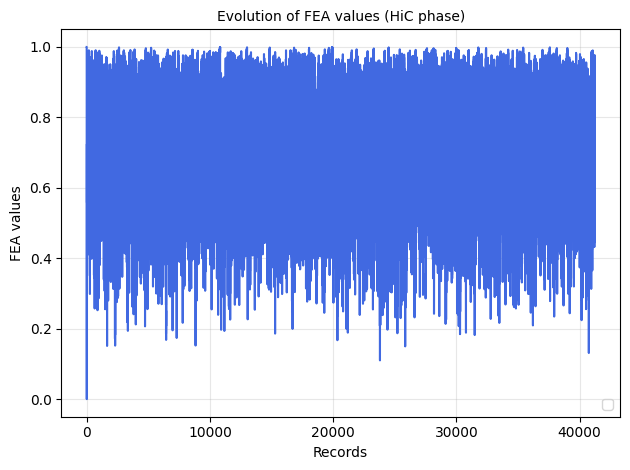

In [31]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
print(np.average(hic_feas))

0.7200527222051125


#### MIC

In [35]:
acc_nt_switch= pd.read_csv(r".\processed_data\CDC_data\switch_ds\acc_nt_switch")
acc_nt_switch = acc_nt_switch.rename(columns={'g_truth':'Diabetes_binary'})

device = torch.device("cpu")

In [ ]:
mic_net = DeferralNet(input_size=21, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.4) 

X_stream= torch.tensor(data= df_batch_3.drop(columns=['Diabetes_binary']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['Diabetes_binary'].values, dtype= torch.long).to(device)


net_path= r".\nets\CDC_diabetes\acc_nt_models\16_8_acc_nt_model_10.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence Based Deferral

Tau = 0.77

In [39]:
acc_nt_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.77, anqi_mao_thresh= 0.2)


acc_nt_mic_df, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=acc_nt_mic.start_MiC(X_stream, y_stream, acc_nt_switch)   #3 minutes


  4%|▎         | 530/14139 [00:01<00:41, 330.25it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.6203782466437436), np.float64(0.5420516501226953), np.float64(0.8103790202573519), np.float64(0.6038069861517567), np.float64(0.8673902964796064)]


  4%|▍         | 549/14139 [00:01<00:48, 279.63it/s]


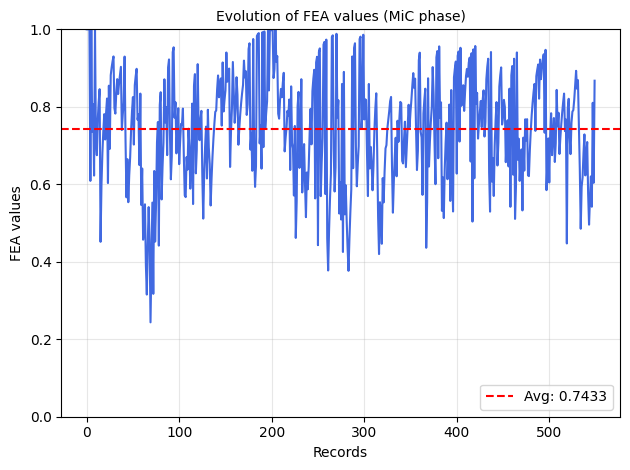

In [40]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [41]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
acc_nt_mic.deferred_decisions

0.9036363636363637
0.7418181818181818


199

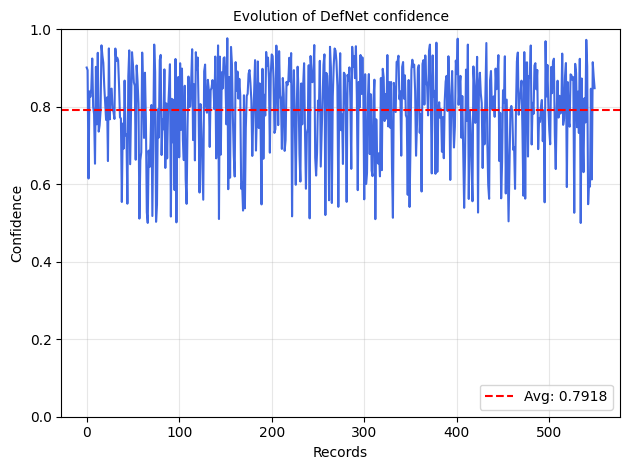

In [42]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

Anqi Mao thresh= 0.1327

In [ ]:
r_net_acc_nt = DeferralNet(input_size=21, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.3)

r_net_acc_nt.load_state_dict(torch.load('r_net_acc_nt.pth'))
r_net_acc_nt.to(device)
r_net_acc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [44]:
acc_nt_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.77, anqi_mao_thresh= 0.1327)


acc_nt_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=acc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net_acc_nt, two_step_deferral=True)   #3 minutes


  4%|▍         | 544/14139 [00:01<00:44, 307.91it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.6203782466437436), np.float64(0.5420516501226953), np.float64(0.8103790202573519), np.float64(0.6038069861517567), np.float64(0.8673902964796064)]


  4%|▍         | 549/14139 [00:02<00:49, 272.80it/s]


In [45]:
print(mic_acc_3)
print(model_acc_3)
acc_nt_strat_2.deferred_decisions


0.889090909090909
0.7418181818181818


208

### Expert: Inaccurate, Not Trusting (ok)

#### HIC

In [ ]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_not_trusting']
name= f"{'inaccurate_not_trusting'}"


hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, clean_prepr,
                0.80, current_expert,
                protected, categoricals, numericals, 0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, arf_mod
)
    


In [ ]:
hic_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

hic_df= pd.DataFrame(hic_df)

hic_df.to_csv(f".\processed_data\CDC_data\hic_results_ds\hic_{name}", index=False)  # 152 minuti

Accuracy: 71.00%
F1: 72.38%
Distribution of predictions: Counter({1: 104, 0: 96})
ARFClassifier trained


  1%|          | 274/41215 [00:01<02:29, 274.60it/s]

  6%|▋         | 2636/41215 [00:37<11:42, 54.94it/s]  

  7%|▋         | 2726/41215 [00:42<12:24, 51.69it/s]  

  7%|▋         | 2786/41215 [00:45<15:33, 41.18it/s]  

  8%|▊         | 3188/41215 [00:57<13:59, 45.31it/s]  

  9%|▊         | 3523/41215 [01:11<14:45, 42.56it/s]  

  9%|▉         | 3825/41215 [01:21<15:56, 39.10it/s]  

 10%|▉         | 4113/41215 [01:33<17:03, 36.26it/s]  

 12%|█▏        | 5047/41215 [02:11<22:10, 27.19it/s]  

 12%|█▏        | 5107/41215 [02:16<21:09, 28.45it/s]  

 13%|█▎        | 5162/41215 [02:21<22:49, 26.33it/s]  

 13%|█▎        | 5180/41215 [02:25<52:42, 11.39it/s]  

 14%|█▍        | 5825/41215 [02:56<23:38, 24.95it/s]  

 14%|█▍        | 5927/41215 [03:04<24:09, 24.35it/s]  

 14%|█▍        | 5972/41215 [03:09<25:37, 22.92it/s]  

 17%|█▋        | 7079/41215 [04:30<31:48, 17.89it/s]  

 18%|█▊        | 7546/41215 [04:58<29:40, 18.91it/s]  

 20%|█▉        | 8073/41215 [05:39<30:34, 18.06it/s]  

 21%|██▏       | 8775/41215 [06:35<33:04, 16.35it/s]   

 21%|██▏       | 8795/41215 [06:40<46:34, 11.60it/s]  

 22%|██▏       | 8891/41215 [06:50<33:42, 15.99it/s]  

 22%|██▏       | 8999/41215 [07:00<33:40, 15.94it/s]  

 25%|██▍       | 10277/41215 [08:45<36:05, 14.29it/s]  

 25%|██▌       | 10331/41215 [09:02<44:53, 11.47it/s]   

 27%|██▋       | 10987/41215 [09:56<38:02, 13.24it/s]  

 27%|██▋       | 10997/41215 [10:00<1:48:26,  4.64it/s]

 30%|███       | 12419/41215 [12:29<40:32, 11.84it/s]   

 31%|███       | 12587/41215 [12:48<41:02, 11.63it/s]  

 31%|███       | 12695/41215 [13:02<41:58, 11.32it/s]  

 31%|███       | 12747/41215 [13:12<42:01, 11.29it/s]  

 31%|███       | 12771/41215 [13:19<49:18,  9.61it/s]  

 31%|███       | 12839/41215 [13:30<41:28, 11.40it/s]  

 31%|███       | 12877/41215 [13:38<42:32, 11.10it/s]  

 33%|███▎      | 13537/41215 [14:57<42:55, 10.75it/s]   

 34%|███▍      | 14033/41215 [15:59<46:05,  9.83it/s]   

 35%|███▌      | 14559/41215 [17:09<44:49,  9.91it/s]   

 36%|███▌      | 14729/41215 [17:31<45:38,  9.67it/s]  

 36%|███▋      | 15042/41215 [18:20<46:28,  9.39it/s]   

 46%|████▌     | 18787/41215 [26:56<48:28,  7.71it/s]   

 51%|█████     | 20827/41215 [34:18<52:15,  6.50it/s]   

 51%|█████     | 21021/41215 [35:23<53:41,  6.27it/s]   

 52%|█████▏    | 21259/41215 [36:15<51:16,  6.49it/s]   

 54%|█████▎    | 22067/41215 [39:11<51:56,  6.14it/s]   

 54%|█████▍    | 22371/41215 [40:16<52:02,  6.03it/s]   

 55%|█████▌    | 22835/41215 [42:03<55:04,  5.56it/s]   

 56%|█████▌    | 22999/41215 [42:38<50:46,  5.98it/s]   

 57%|█████▋    | 23588/41215 [44:54<51:39,  5.69it/s]   

 59%|█████▉    | 24492/41215 [48:27<50:01,  5.57it/s]   

 60%|█████▉    | 24529/41215 [48:41<50:40,  5.49it/s]   

 62%|██████▏   | 25487/41215 [52:50<49:33,  5.29it/s]   

 65%|██████▌   | 26889/41215 [58:31<46:02,  5.19it/s]   

 65%|██████▌   | 26933/41215 [58:48<47:37,  5.00it/s]   

 65%|██████▌   | 26945/41215 [58:59<59:10,  4.02it/s]   

 67%|██████▋   | 27538/41215 [1:01:49<46:52,  4.86it/s]   

 67%|██████▋   | 27643/41215 [1:02:18<45:00,  5.03it/s]   

 69%|██████▉   | 28463/41215 [1:05:59<45:08,  4.71it/s]   

 70%|███████   | 29004/41215 [1:09:27<16:36:40,  4.90s/it]

 71%|███████   | 29154/41215 [1:10:07<42:58,  4.68it/s]   

 72%|███████▏  | 29501/41215 [1:11:32<42:35,  4.58it/s]  

 72%|███████▏  | 29602/41215 [1:12:04<43:10,  4.48it/s]   

 72%|███████▏  | 29732/41215 [1:12:42<42:17,  4.53it/s]  

 72%|███████▏  | 29866/41215 [1:13:29<41:09,  4.60it/s]  

 73%|███████▎  | 30042/41215 [1:15:10<44:59,  4.14it/s]   

 74%|███████▍  | 30469/41215 [1:16:54<40:17,  4.44it/s]  

 74%|███████▍  | 30589/41215 [1:17:31<39:28,  4.49it/s]  

 74%|███████▍  | 30686/41215 [1:18:03<39:27,  4.45it/s]  

 75%|███████▍  | 30799/41215 [1:18:47<38:08,  4.55it/s]  

 75%|███████▌  | 31053/41215 [1:21:38<38:21,  4.42it/s]   

 76%|███████▌  | 31291/41215 [1:22:42<39:00,  4.24it/s]  

 78%|███████▊  | 31945/41215 [1:26:01<35:57,  4.30it/s]  

 78%|███████▊  | 32107/41215 [1:27:45<35:51,  4.23it/s]   

 79%|███████▉  | 32743/41215 [1:30:25<33:50,  4.17it/s]  

 81%|████████  | 33193/41215 [1:33:58<32:03,  4.17it/s]   

 81%|████████▏ | 33525/41215 [1:35:50<31:21,  4.09it/s]  

 82%|████████▏ | 33592/41215 [1:36:16<31:01,  4.09it/s]  

 84%|████████▎ | 34489/41215 [1:41:37<28:07,  3.98it/s]   

 85%|████████▍ | 34831/41215 [1:43:13<26:46,  3.97it/s]  

 87%|████████▋ | 35921/41215 [1:50:22<22:46,  3.87it/s]   

 87%|████████▋ | 35980/41215 [1:50:48<22:48,  3.83it/s]  

 91%|█████████ | 37424/41215 [2:01:10<16:49,  3.76it/s]   

 91%|█████████ | 37430/41215 [2:01:22<48:40,  1.30it/s]  

 92%|█████████▏| 37739/41215 [2:02:58<16:06,  3.60it/s]  

 92%|█████████▏| 37922/41215 [2:04:00<15:12,  3.61it/s]  

 93%|█████████▎| 38259/41215 [2:07:18<13:49,  3.56it/s]   

 93%|█████████▎| 38343/41215 [2:07:52<13:35,  3.52it/s]  

 93%|█████████▎| 38395/41215 [2:08:17<12:58,  3.62it/s]  

 94%|█████████▍| 38683/41215 [2:09:58<11:56,  3.54it/s]  

 95%|█████████▌| 39334/41215 [2:15:46<08:44,  3.58it/s]   

 96%|█████████▌| 39437/41215 [2:16:27<08:31,  3.48it/s]  

 96%|█████████▌| 39513/41215 [2:17:11<08:09,  3.48it/s]  

 96%|█████████▋| 39716/41215 [2:18:21<07:13,  3.46it/s]  

 96%|█████████▋| 39730/41215 [2:18:36<07:56,  3.12it/s]  

 99%|█████████▊| 40611/41215 [2:25:05<02:53,  3.49it/s]   

 99%|█████████▊| 40695/41215 [2:25:42<02:30,  3.46it/s]

100%|██████████| 41215/41215 [2:31:25<00:00,  4.54it/s]  


In [48]:
blueprint= pd.read_csv(r".\processed_data\CDC_data\hic_results_ds\hic_inaccurate_not_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\CDC_data\calibration_datasets\inacc_nt_calibration", index= False)


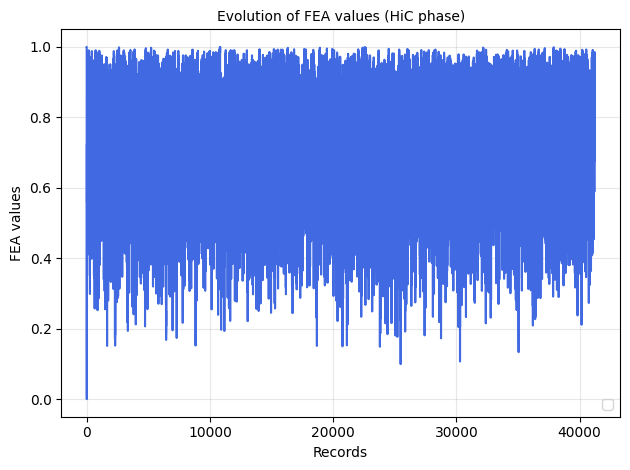

In [49]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### MIC

In [50]:
inacc_nt_switch= pd.read_csv(r".\processed_data\CDC_data\switch_ds\inacc_nt_switch")
inacc_nt_switch = inacc_nt_switch.rename(columns={'g_truth':'Diabetes_binary'})

device = torch.device("cpu")

In [ ]:
mic_net = DeferralNet(input_size=21, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.4) 
mic_net.to(device)

X_stream= torch.tensor(data= df_batch_3.drop(columns=['Diabetes_binary']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['Diabetes_binary'].values, dtype= torch.long).to(device)


net_path= r".\nets\CDC_diabetes\inacc_nt_models\16_8_inacc_nt_model_10.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Deferral Strat 1

net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.4)
tau= 0.78

In [53]:
inacc_nt_mic_strat_1= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.78, anqi_mao_thresh= 0.2)


inacc_nt_mic, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=inacc_nt_mic_strat_1.start_MiC(X_stream, y_stream, inacc_nt_switch)   #3 minutes


  4%|▍         | 575/14139 [00:01<00:47, 283.02it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.47500511577235477), np.float64(0.5573853195506383), np.float64(0.6230985850070215), np.float64(0.6764690047979306), np.float64(0.7204521688747841)]


  4%|▍         | 588/14139 [00:02<00:52, 256.01it/s]


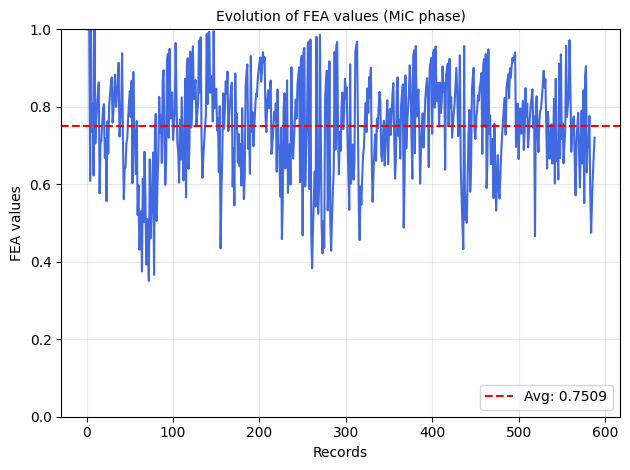

In [54]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [55]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
acc_nt_mic.deferred_decisions

0.8879456706281834
0.7521222410865874


199

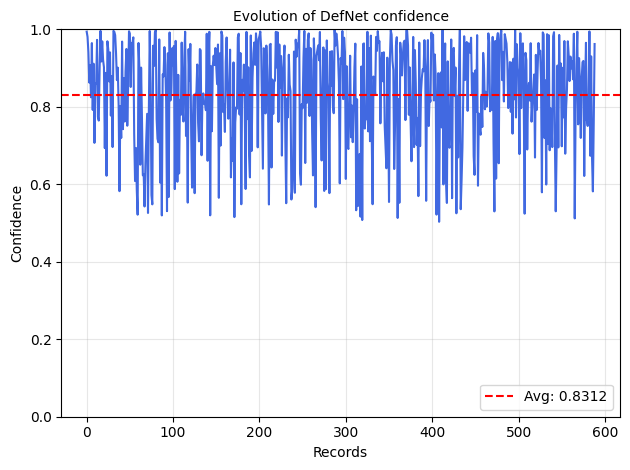

In [56]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Deferral Strat 2

anqi mao thresh= 0.132653

In [ ]:
r_net_inacc_nt = DeferralNet(input_size=21, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.3)

r_net_inacc_nt.load_state_dict(torch.load('r_net_inacc_nt.pth'))
r_net_inacc_nt.to(device)
r_net_inacc_nt.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [58]:
inacc_nt_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.77, anqi_mao_thresh= 0.132653)


inacc_nt_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=inacc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net_acc_nt, two_step_deferral=True)   #3 minutes


  4%|▍         | 567/14139 [00:01<00:50, 268.15it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.47500511577235477), np.float64(0.5573853195506383), np.float64(0.6230985850070215), np.float64(0.6764690047979306), np.float64(0.7204521688747841)]


  4%|▍         | 588/14139 [00:02<00:55, 244.02it/s]


In [59]:
print(mic_acc_3)
print(model_acc_3)
acc_nt_strat_2.deferred_decisions


0.8811544991511036
0.7521222410865874


208